In [1]:
# imports for simulations
import jax.numpy as np
import numpy as np2
from jax import random, vmap, pmap, jit
from jax.lax import fori_loop
from jax.nn import relu
from jax.ops import index_add

import functools
import matplotlib.pyplot as plt
from matplotlib import colors
import time
import tqdm

import collections
import numpy as np2
import random as random2
import networkx as nx
import scipy.stats as ss
import scipy.sparse as sparse
import math
from itertools import combinations
import pandas as pd
import itertools
%matplotlib inline

ModuleNotFoundError: No module named 'jax'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
plt.rcParams['pdf.fonttype'] = 42

## Plot definitions

In [4]:
%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

greens = plt.get_cmap('Greens')
purples = plt.get_cmap('Purples')
greys = plt.get_cmap('Greys')
plt.rc('lines',linewidth=2)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE, frameon=False)    # legend fontsize
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

ModuleNotFoundError: No module named 'matplotlib'

# Defining the 3 layer network


## Defining functions


In [0]:
# Create fully connected groups for household
def create_house_neighbourhoods(pop, dist_groups, neighbourhood_size, percent_external):
    """ Divide the population into households depending upon their distribution of sizes and then constructing neighbourhoods
    @param pop : Total size of the population
    @type : int
    @param dist_groups : Dist of sizes of households in the population
    @type : list
    @return : Adjacency matrix of household and neighbourhood layers
    @type : 2D array
    """
    matrix_household = np2.zeros((pop,pop))
    matrix_neighbourhood = np2.zeros((pop,pop))
    matrix_external = np2.zeros((pop,pop))

    external_connections = []
    neighbourhood_size = neighbourhood_size
    neighbourhood_tracker = []
    counter = 0
    indices = np2.arange(0,pop,1)
    no_households = len(dist_groups)
    no_external = int(neighbourhood_size*percent_external/100)
    
    for indx, size in enumerate(dist_groups):
        # Create household
        house = indices[:int(size)]
        comb = list(itertools.combinations(house,2))
        for i,j in comb:
            matrix_household[i][j] = 1
            matrix_household[j][i] = 1
        neighbourhood_tracker.extend(house)
        counter += size
        
        # Create neighbourhood if neighbourhood size is reached
        if counter >= neighbourhood_size or indx == no_households-1:
            external_connections.extend(np2.random.choice(neighbourhood_tracker,size=no_external,replace=False))
            comb = list(itertools.combinations(neighbourhood_tracker,2))
            for i,j in comb:
                matrix_neighbourhood[i][j] = 1
                matrix_neighbourhood[j][i] = 1
            neighbourhood_tracker = []
            counter = 0
        indices = [i for i in indices if i not in house]
    
    # Add external connections
    comb = list(itertools.combinations(external_connections,2))
    for i,j in comb:
        matrix_external[i][j] = 1
        matrix_external[j][i] = 1
    return np2.sign(matrix_household), np2.sign(matrix_neighbourhood - matrix_household), np2.maximum(matrix_external-matrix_neighbourhood,0)

In [0]:
# Create external connections
def create_external(pop,degree_dist):
    """ Create random external connections
    @param pop : Total population size
    @type : int
    @param degree_dist : Degree distribution for this layer
    @type : list
    @return : Adjacency matrix 
    @type : 2D array
    """
    # Create external stubs that are randomly connected 
    matrix = np2.zeros((pop,pop))
    external_stubs = []
    
    for i in range(pop):
        stubs = degree_dist[i]
        external_stubs.extend([i for j in range(stubs)])
      
    # Attach the random stubs        
    external_pairs = np2.random.choice(external_stubs, size = (int(len(external_stubs)/2),2), replace = False)
    for pairs in range(len(external_pairs)):
        i = external_pairs[pairs][0]
        j = external_pairs[pairs][1] 
        matrix[i][j] = 1
        matrix[j][i] = 1

    return np2.sign(matrix)

## Inputs
### Population size

In [0]:
pop = 1000

### Households

In [0]:
# % Household sizes in China from 2010. 

one_house = 13.66
two_house = 24.37
three_house = 26.86
four_house = 17.56
five_house = 16.66
total_house = one_house + two_house + three_house + four_house + five_house

house_size_dist = np2.array([one_house,two_house,three_house,four_house,five_house])/total_house

# House-hold sizes
household_sizes = []
pop_house = 0

while pop_house <= pop:
    size = np2.random.choice(np.arange(1,6,1),p=house_size_dist,size=1)
    household_sizes.append(size)
    pop_house += size

household_sizes[-1] -= pop_house-pop

# Mean of household degree dist 
mean_household = sum((np2.asarray(household_sizes)-1)*np2.asarray(household_sizes))/pop
print(mean_household)

[2.5]


### Neighbourhoods

In [0]:
neighbourhood_size = 100
perc_neighbourhood_external=10

### Create households and neighbourhoods and external connections. Only 10% of people from each neighborhood are fully connected externally.

In [0]:
matrix_household, matrix_neighbourhood, matrix_external = create_house_neighbourhoods(pop,household_sizes,neighbourhood_size,perc_neighbourhood_external)

# Stochastic simulation

In [0]:
def simulate_sir(w, total_steps, infection_len_sampler, resistence_len_sampler,
                 init_i, init_r, key=0, epoch_len=1):
  """Simulates microscopic SIR dynamics on a weighted, directed graph.

  The simulation is Markov chain, whose state is recorded by two device arrays,
  i and r. The jth entry of i indicates the remaining time steps that individual
  j will stay infected (time until recovery). The jth entry of r indicates the 
  remaining time steps that individual j is immune to infection (time until
  loss off immunity)
  
  Args:
    w: A DeviceArray of shape [n, n], where n is the population size. The entry
      ij represents the probability that individual i infects j.
    total_steps: The total number of updates to the Markov chain.
    infection_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains infected.
    resistence_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains resistant.
    init_i: A DeviceArray of shape [n] containing ints for the initial state of
      infected individuals for the simulation. It records the number of time 
      steps the individual will remain infected.
    init_r: A DeviceArray of shape [n] containing ints for the initial state of
      recovered individuals for the simulation. It records the number of time 
      steps the individual will remain immune.
    key: An int to use as the PRNGKey.
    epoch_len: The number of steps that are JIT'ed in the computation. After
      each epoch the current state of the Markov chain is logged.
    
  Returns:
    The final states of i and s, and a list containing the history of the Markov
    chain.
  """
  n = w.shape[0]
  key = random.PRNGKey(key)

  @jit
  def interaction_sampler(key, w):
    key, subkey = random.split(key)
    keys = random.split(subkey, n**2)
    keys = np.reshape(keys, [n, n, 2])

    return key, vmap(vmap(lambda k, p: random.bernoulli(k, p)))(keys, w)

  @jit
  def interaction_step(key, i, r):
    key, interaction_sample = interaction_sampler(key, w)
    bool_i = np.sign(i)
    bool_r = np.sign(r)
    new_infections = (1-bool_r) * (1-bool_i) * np.sign(
        bool_i @ interaction_sample)
    key, infection_lens = infection_len_sampler(key)
    return (key, i + new_infections * infection_lens, r)
    
  @jit
  def clearing_step(key, i, r):
    newly_recovered = i == 1
    key, resistence_lens = resistence_len_sampler(key)
    r = r + newly_recovered * resistence_lens
    return (key, relu(i-1), relu(r-1))

  def eval_fn(t, i, r, history):
    # print('i({}): {}'.format(t, np.mean(np.sign(i))))
    # print('r({}): {}'.format(t, np.mean(np.sign(r))))
    history.append([np.mean(np.sign(i)), np.mean(np.sign(r))])
    return history

  @jit
  def step(t, args):
    return clearing_step(*interaction_step(*args))
    
  i = init_i
  r = init_r

  epochs = int(total_steps // epoch_len)
  history = []
  for epoch in tqdm.tqdm(range(epochs), total=epochs, position=0):
    key, i, r = fori_loop(0, epoch_len, step, (key, i, r))
    history = eval_fn(epoch*epoch_len, i, r, history)
  return i, r, history

In [0]:
def geometric(key, p, shape=()):
  shape_ = shape
  if shape_ == ():
    try:
      shape_ = p.shape
    except:
      shape_ = ()
  return _geometric(key, p, shape_)

@functools.partial(jit, static_argnums=(2,))
def _geometric(key, p, shape):
  u = random.uniform(key, shape=shape)
  return np.where(u <= p, np.zeros(shape, dtype=np.int32), np.ceil(
      np.log(1. - u) / np.log(1. - p) - .1).astype(np.int32))

## Defining parameters for exponentially distributed times

In [0]:
Tmax = 300 # total time to run simulation for
n = pop # total population size
AvgDurInf = 10. # average duration of infection
delta_t = 0.1 # timestep 
total_steps = int(Tmax / delta_t) # total timesteps to run simulation
tvec=np2.arange(0,Tmax,delta_t)
mean_infection_len = AvgDurInf / delta_t # average length of infection in timestep units

init_num_inf=1 #integar, initial # of ppl infected
beta=0.15
infect_prob=beta*delta_t

In [0]:
# Vector of distribution of infection lengths for each individual. 
# Exponentially distributed waiting times
@jit 
def infection_len_sampler(key):
  #return key, int(mean_infection_len) * np.ones([n])
  key, subkey = random.split(key)
  return key, 1 + geometric(subkey, p=1./mean_infection_len, shape=[n])

# Vector of distribution of duration of immunity for each individual
# Fixed duration
@jit
def resistence_len_sampler(key): 
  return key, 2**20 * np.ones([n])

# Results

## Without intervention

### Sparse
Neighborhood size = 100, pop = 1,000, iterations = 10

In [0]:
# Define adjacency matrix
# Weights of the connections per layer

w_house = 1
w_neighbourhood = 0.01
w_external= 1e-4
adjacency_matrix = (w_house*matrix_household) + (w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external)
mean_degree = sum(sum(adjacency_matrix))/pop
w = infect_prob * adjacency_matrix # contact network multiplied by transmission rate

In [0]:
# Calculate R0 for each component and see if it's reasonable. 
# They should all be of order 1
R0=beta*AvgDurInf*(mean_degree-1)
R0HH=beta*AvgDurInf*w_house*(sum(sum(matrix_household))/pop-1)
R0N=beta*AvgDurInf*w_neighbourhood*sum(sum(matrix_neighbourhood))/pop
R0EX=beta*AvgDurInf*w_external*sum(sum(matrix_external))/pop
print(R0)
print(R0HH)
print(R0N)
print(R0N*mean_household[0])
print(R0EX)
print(R0EX*neighbourhood_size)

#infect_prob = R0 / (mean_infection_len * (mean_degree-1)) # probability of infection per timestep per contact


3.7001399999999682
2.25
1.44879
3.621975
0.00135
0.135


In [0]:
soln_i = []
soln_r = []

number_trials = 1

for key in range(number_trials):

  #Initial condition
  _, init_i = infection_len_sampler(random.PRNGKey(key+100))
  init_ind = int(random.uniform(random.PRNGKey(key), shape=(init_num_inf,), maxval=n))
  init_state=np.zeros(n)
  init_state=index_add(init_state,init_ind,np.squeeze(np.ones(init_num_inf)))
  init_i=init_i*init_state
  init_r = np.zeros([n])

  #_, init_i = infection_len_sampler(random.PRNGKey(key+1000))
  #init_i = init_i * np.hstack(
  #    [np.ones(init_num_inf), np.zeros(n-init_num_inf)])
  #init_r = np.zeros([n])

  #Run simulation
  i, r, history = simulate_sir(
      w, total_steps, infection_len_sampler, resistence_len_sampler, 
      init_i, init_r, epoch_len=1, key=key)
  soln = np.array(history)
  soln_i.append(soln[:,0])
  soln_r.append(soln[:,1])

100%|██████████| 3000/3000 [00:15<00:00, 192.50it/s]


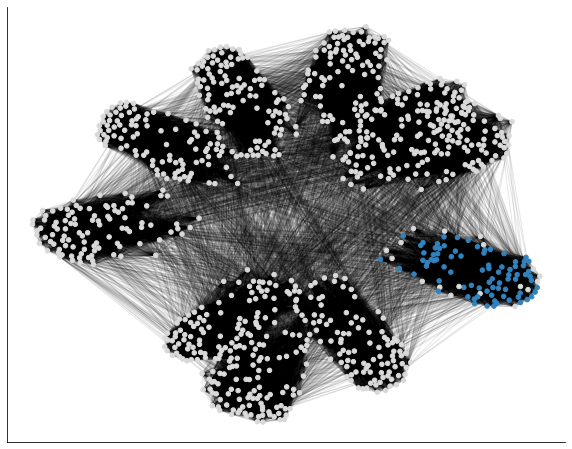

In [0]:
# Visualise the network with yellow nodes corresponding to susceptible and green are recovered individuals.
G = nx.from_numpy_matrix((w))
values = []
for i in range(len(r)):
    if r[i] > 0:
        values.append(0) #Blue
    else:
        values.append(1) #White

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=20, cmap = plt.get_cmap('tab20c'), node_color=values)
nx.draw_networkx_edges(G, pos, alpha=0.1)
#plt.savefig('/content/gdrive/My Drive/COVID19 Network Simulations/figures/networksparse.pdf',bbox_inches='tight')
plt.show()

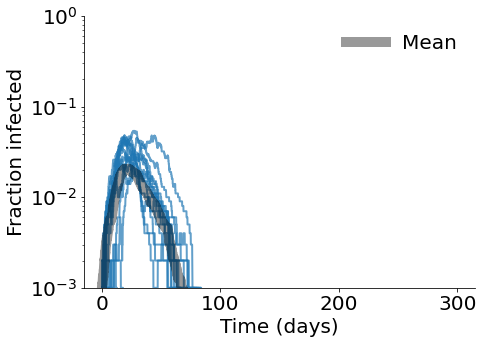

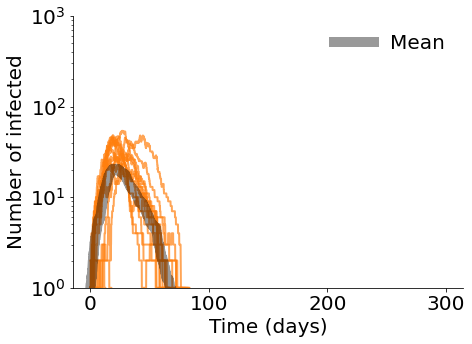

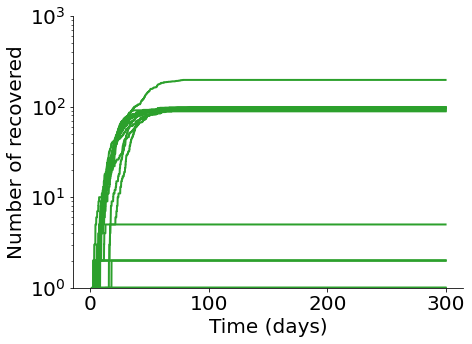

In [0]:
#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(1,figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i],color='C0',alpha=0.7)
plt.plot(tvec,mean_traj,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.xlabel("Time (days)")
plt.ylabel("Fraction infected")
plt.ylim([1/pop,1])
plt.legend()
plt.semilogy()
plt.savefig('/content/gdrive/My Drive/COVID19 Network Simulations/figures/scenario2sparse.pdf',bbox_inches='tight')
plt.show() # NOTE: YOU MUST SAVE BEFORE SHOWING!!


#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(1,figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i]*pop,color='C1',alpha=0.7)
plt.plot(tvec,mean_traj*pop,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.xlabel("Time (days)")
plt.ylabel("Number of infected")
plt.ylim([1,pop])
plt.legend()
plt.semilogy()
plt.show()
#plt.savefig('scenario2sparse.pdf',bbox_inches='tight')


#plot recovered

plt.figure(2,figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_r[i]*pop,color='C2',alpha=1)
plt.xlabel("Time (days)")
plt.ylabel("Number of recovered")
plt.ylim([1,pop])
plt.semilogy()
plt.show()

### Crowded (changing weights)
neighborhood = 100, pop = 1000, iterations = 10

In [0]:
# Define adjacency matrix
# Weights of the connections per layer

w_house = 1
w_neighbourhood = 0.01
w_external= 1e-3
adjacency_matrix = (w_house*matrix_household) + (w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external)
mean_degree = sum(sum(adjacency_matrix))/pop
w = infect_prob * adjacency_matrix # contact network multiplied by transmission rate

In [0]:
# Calculate R0 for each component and see if it's reasonable. 
# They should all be of order 1
R0=beta*AvgDurInf*(mean_degree-1)
R0HH=beta*AvgDurInf*w_house*(sum(sum(matrix_household))/pop-1)
R0N=beta*AvgDurInf*w_neighbourhood*sum(sum(matrix_neighbourhood))/pop
R0EX=beta*AvgDurInf*w_external*sum(sum(matrix_external))/pop
print(R0)
print(R0HH)
print(R0N)
print(R0N*mean_household[0])
print(R0EX)
print(R0EX*neighbourhood_size)

#infect_prob = R0 / (mean_infection_len * (mean_degree-1)) # probability of infection per timestep per contact


3.71228999999997
2.25
1.44879
3.621975
0.0135
1.35


In [0]:
soln_i = []
soln_r = []

number_trials = 1

for key in range(number_trials):

  #Initial condition
  _, init_i = infection_len_sampler(random.PRNGKey(key+1))
  init_ind = int(random.uniform(random.PRNGKey(key), shape=(init_num_inf,), maxval=n))
  init_state=np.zeros(n)
  init_state=index_add(init_state,init_ind,np.squeeze(np.ones(init_num_inf)))
  init_i=init_i*init_state
  init_r = np.zeros([n])

  #_, init_i = infection_len_sampler(random.PRNGKey(key+1000))
  #init_i = init_i * np.hstack(
  #    [np.ones(init_num_inf), np.zeros(n-init_num_inf)])
  #init_r = np.zeros([n])

  #Run simulation
  i, r, history = simulate_sir(
      w, total_steps, infection_len_sampler, resistence_len_sampler, 
      init_i, init_r, epoch_len=1, key=key+10)
  soln = np.array(history)
  soln_i.append(soln[:,0])
  soln_r.append(soln[:,1])

100%|██████████| 3000/3000 [00:16<00:00, 182.60it/s]


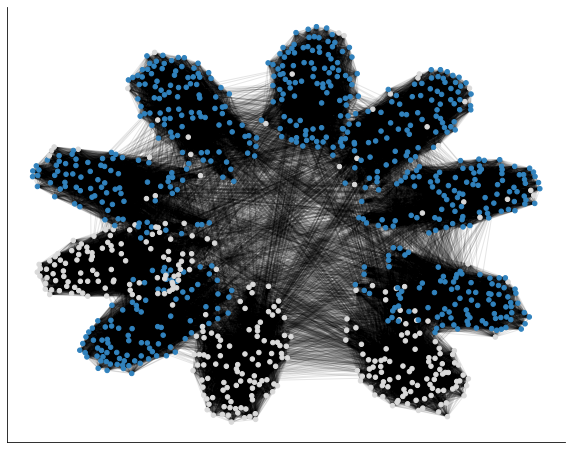

In [0]:
# Visualise the network with yellow nodes corresponding to susceptible and green are recovered individuals.
G = nx.from_numpy_matrix((w))
values = []
for i in range(len(r)):
    if r[i] > 0:
        values.append(0) #Blue
    else:
        values.append(1) #white

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=20, cmap = plt.get_cmap('tab20c'), node_color=values)
nx.draw_networkx_edges(G, pos, alpha=0.1)
#plt.savefig('/content/gdrive/My Drive/COVID19 Network Simulations/figures/networkcrowded.pdf',bbox_inches='tight')
plt.show()

In [0]:
#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(1,figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i],color='C0',alpha=0.7)
plt.plot(tvec,mean_traj,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.xlabel("Time (days)")
plt.ylabel("Fraction infected")
plt.ylim([1/pop,1])
plt.legend()
plt.semilogy()
plt.savefig('/content/gdrive/My Drive/COVID19 Network Simulations/figures/scenario2crowded.pdf',bbox_inches='tight',transparent=True)
plt.show() # NOTE: YOU MUST SAVE BEFORE SHOWING!!

#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(1,figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i]*pop,color='C1',alpha=0.7)
plt.plot(tvec,mean_traj*pop,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.xlabel("Time (days)")
plt.ylabel("Number of infected")
plt.ylim([1,pop])
plt.legend()
plt.semilogy()
plt.show()
#plt.savefig('scenario2sparse.pdf',bbox_inches='tight')


#plot recovered

plt.figure(2,figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_r[i]*pop,color='C2',alpha=1)
plt.xlabel("Time (days)")
plt.ylabel("Number of recovered")
plt.ylim([1,pop])
plt.semilogy()
plt.show()

## With intervention

Same intervention given to both populations, but post-intervetion there will be more residual connections in the more crowded population, allowing continual spread. Intervention efficacy = 75%

### Code

In [0]:
def simulate_intervention(
    ws, step_intervals, infection_len_sampler, resistence_len_sampler,
    init_i, init_r, key=0, epoch_len=1):
  """Simulates microscopic SIR dynamics on a weighted, directed graph.

  The simulation is Markov chain, whose state is recorded by two device arrays,
  i and r. The jth entry of i indicates the remaining time steps that individual
  j will stay infected. The jth entry of r indicates the remaining time steps
  that individual j is resistant to infection.
  
  Args:
    ws: A list of DeviceArrays of shape [n, n], where n is the population size.
      The dynamics will be simulated on each strucutre sequentially.
    step_intervals: A list of ints indicating the number fo simulation steps
      performed on each population strucutre.
    infection_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains infected.
    resistence_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains resistant.
    init_i: A DeviceArray of shape [n] containing ints for the initial state of
      infected for the simulation. It records the number of time steps the 
      individual will remain infected.
    init_r: A DeviceArray of shape [n] containing ints for the initial state of
      resistant for the simulation. It records the number of time steps the 
      individual will remain resistant.
    key: An int to use as the PRNGKey.
    epoch_len: The number of steps that are JIT'ed in the computation. After
      each epoch the current state of the Markov chain is logged.
    
  Returns:
    The final states of i and r, and a list containing the history of the Markov
    chain.
  """

  history = []
  i, r = init_i, init_r
  for t, (w, total_steps) in enumerate(zip(ws, step_intervals)):
    i, r, history_ = simulate_sir(
        w, total_steps, infection_len_sampler, resistence_len_sampler,
        i, r, key=0, epoch_len=1)
    history.extend(history_)
    print('Completed interval {} of {}'.format(t+1, len(ws)))

  return i, r, history

### Sparse


In [0]:
# Vector of distribution of infection lengths for each individual. 
# Exponentially distributed waiting times
@jit 
def infection_len_sampler(key):
  #return key, int(mean_infection_len) * np.ones([n])
  key, subkey = random.split(key)
  return key, 1 + geometric(subkey, p=1./mean_infection_len, shape=[n])

# Vector of distribution of duration of immunity for each individual
# Fixed duration
@jit
def resistence_len_sampler(key): 
  return key, 2**20 * np.ones([n])

In [0]:
# Define adjacency matrix
# Weights of the connections per layer
w_house = 1
w_neighbourhood = 0.01
w_external= 1e-3
adjacency_matrix = (w_house*matrix_household) + (w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external)
mean_degree = sum(sum(adjacency_matrix))/pop

# post intervention
npi=0.75 #efficacy of intervention
adjacency_matrix_npi = (w_house*matrix_household) + ((w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external))*(1-npi)


In [0]:
Tint=15
Lint=275
n = pop # total population size
AvgDurInf = 10. # average duration of infection
delta_t = 0.1 # timestep 

days_list = [Tint, Lint]
days = np.sum(days_list)
step_intervals = [int(days / delta_t) for days in days_list]
total_steps = np.sum(step_intervals)
tvec=np2.arange(0,Tint+Lint,delta_t)

mean_infection_len = AvgDurInf / delta_t # average length of infection in timestep units

init_num_inf=1 #integar, initial # of ppl infected
beta=0.15
infect_prob=beta*delta_t

w1 = infect_prob * adjacency_matrix # contact network multiplied by transmission rate

w2 = infect_prob * adjacency_matrix_npi

ws = [w1, w2]

In [0]:
# Calculate R0 for each component and see if it's reasonable. 
# They should all be of order 1
R0=beta*AvgDurInf*(mean_degree-1)
R0HH=beta*AvgDurInf*w_house*(sum(sum(matrix_household))/pop-1)
R0N=beta*AvgDurInf*w_neighbourhood*sum(sum(matrix_neighbourhood))/pop
R0EX=beta*AvgDurInf*w_external*sum(sum(matrix_external))/pop
print(R0)
print(R0HH)
print(R0N)
print(R0N*mean_household[0])
print(R0EX)
print(R0EX*neighbourhood_size)

3.8629199999999626
2.4000000000000004
1.44942
3.7684919999999997
0.0135
1.35


In [0]:
# Post intervention
R0HH=beta*AvgDurInf*w_house*(sum(sum(matrix_household))/pop-1)
R0N=beta*AvgDurInf*(1-npi)*w_neighbourhood*sum(sum(matrix_neighbourhood))/pop
R0EX=beta*AvgDurInf*(1-npi)*w_external*sum(sum(matrix_external))/pop
print(R0HH)
print(R0N)
print(R0N*mean_household[0])
print(R0EX)
print(R0EX*neighbourhood_size)

2.4000000000000004
0.362355
0.9421229999999999
0.003375
0.3375


In [0]:
soln_i = []
soln_r = []

number_trials = 20

for key in range(number_trials):

  #Initial condition
  _, init_i = infection_len_sampler(random.PRNGKey(key))
  init_ind = int(random.uniform(random.PRNGKey(key), shape=(init_num_inf,), maxval=n))
  init_state=np.zeros(n)
  init_state=index_add(init_state,init_ind,np.squeeze(np.ones(init_num_inf)))
  init_i=init_i*init_state
  init_r = np.zeros([n])

  #_, init_i = infection_len_sampler(random.PRNGKey(key+1000))
  #init_i = init_i * np.hstack(
  #    [np.ones(init_num_inf), np.zeros(n-init_num_inf)])
  #init_r = np.zeros([n])

  #Run simulation
  i, r, history = simulate_intervention(
      ws, step_intervals, infection_len_sampler, resistence_len_sampler, 
      init_i, init_r, epoch_len=1, key=key)
  soln = np.array(history)
  soln_i.append(soln[:,0])
  soln_r.append(soln[:,1])

  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 200.51it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 204.73it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 208.67it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 208.73it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 208.73it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 207.67it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 211.09it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 210.42it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 210.53it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 211.21it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 211.92it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 213.70it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 209.12it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 213.28it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 211.40it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 215.19it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 216.67it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 215.04it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 218.63it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 211.81it/s]


Completed interval 2 of 2


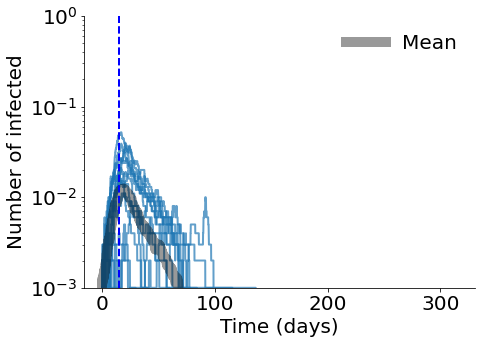

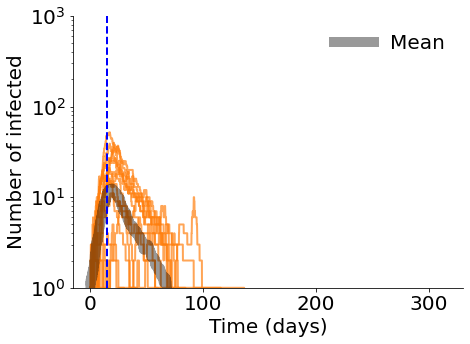

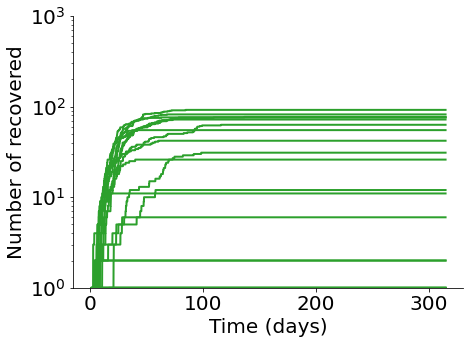

In [0]:
#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i],color='C0',alpha=0.7)
plt.plot(tvec,mean_traj,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.plot([Tint,Tint],[1/pop,1],'b--')
plt.xlabel("Time (days)")
plt.ylabel("Number of infected")
plt.ylim([1/pop,1])
plt.legend()
plt.semilogy()
plt.savefig('/content/gdrive/My Drive/COVID19 Network Simulations/figures/scenario2sparse_int.pdf',bbox_inches='tight',transparent=True)
plt.show() # NOTE: YOU MUST SAVE BEFORE SHOWING!!


#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i]*pop,color='C1',alpha=0.7)
plt.plot(tvec,mean_traj*pop,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.plot([Tint,Tint],[1,pop],'b--')
plt.xlabel("Time (days)")
plt.ylabel("Number of infected")
plt.ylim([1,pop])
plt.legend()
plt.semilogy()
plt.show()
#plt.savefig('scenario2sparse.pdf',bbox_inches='tight')


#plot recovered

plt.figure(figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_r[i]*pop,color='C2',alpha=1)
plt.xlabel("Time (days)")
plt.ylabel("Number of recovered")
plt.ylim([1,pop])
plt.semilogy()
plt.show()

### Crowded


In [0]:
# Define adjacency matrix
# Weights of the connections per layer
w_house = 1
w_neighbourhood = 0.01
w_external= 1e-2
adjacency_matrix = (w_house*matrix_household) + (w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external)
mean_degree = sum(sum(adjacency_matrix))/pop

# post intervention
npi=0.75 #efficacy of intervention
adjacency_matrix_npi = (w_house*matrix_household) + ((w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external))*(1-npi)

In [0]:
Tint=15
Lint=275
n = pop # total population size
AvgDurInf = 10. # average duration of infection
delta_t = 0.1 # timestep 

days_list = [Tint, Lint]
days = np.sum(days_list)
step_intervals = [int(days / delta_t) for days in days_list]
total_steps = np.sum(step_intervals)
tvec=np2.arange(0,Tint+Lint,delta_t)

mean_infection_len = AvgDurInf / delta_t # average length of infection in timestep units

init_num_inf=1 #integar, initial # of ppl infected
beta=0.15
infect_prob=beta*delta_t

w1 = infect_prob * adjacency_matrix # contact network multiplied by transmission rate

w2 = infect_prob * adjacency_matrix_npi

ws = [w1, w2]

In [0]:
# Calculate R0 for each component and see if it's reasonable. 
# They should all be of order 1
R0=beta*AvgDurInf*(mean_degree-1)
R0HH=beta*AvgDurInf*w_house*(sum(sum(matrix_household))/pop-1)
R0N=beta*AvgDurInf*w_neighbourhood*sum(sum(matrix_neighbourhood))/pop
R0EX=beta*AvgDurInf*w_external*sum(sum(matrix_external))/pop
print(R0)
print(R0HH)
print(R0N)
print(R0N*mean_household[0])
print(R0EX)
print(R0EX*neighbourhood_size)

3.9844199999999548
2.4000000000000004
1.44942
3.7684919999999997
0.135
13.5


In [0]:
# Post intervention
R0HH=beta*AvgDurInf*w_house*(sum(sum(matrix_household))/pop-1)
R0N=beta*AvgDurInf*(1-npi)*w_neighbourhood*sum(sum(matrix_neighbourhood))/pop
R0EX=beta*AvgDurInf*(1-npi)*w_external*sum(sum(matrix_external))/pop
print(R0HH)
print(R0N)
print(R0N*mean_household[0])
print(R0EX)
print(R0EX*neighbourhood_size)

2.4000000000000004
0.362355
0.9421229999999999
0.03375
3.375


In [0]:
soln_i = []
soln_r = []

number_trials = 20

for key in range(number_trials):

  #Initial condition
  _, init_i = infection_len_sampler(random.PRNGKey(key))
  init_ind = int(random.uniform(random.PRNGKey(key), shape=(init_num_inf,), maxval=n))
  init_state=np.zeros(n)
  init_state=index_add(init_state,init_ind,np.squeeze(np.ones(init_num_inf)))
  init_i=init_i*init_state
  init_r = np.zeros([n])

  #_, init_i = infection_len_sampler(random.PRNGKey(key+1000))
  #init_i = init_i * np.hstack(
  #    [np.ones(init_num_inf), np.zeros(n-init_num_inf)])
  #init_r = np.zeros([n])

  #Run simulation
  i, r, history = simulate_intervention(
      ws, step_intervals, infection_len_sampler, resistence_len_sampler, 
      init_i, init_r, epoch_len=1, key=key)
  soln = np.array(history)
  soln_i.append(soln[:,0])
  soln_r.append(soln[:,1])

  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 219.54it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 222.66it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 219.50it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 222.52it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 223.35it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 225.23it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 220.73it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:13<00:00, 225.82it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 191.42it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 191.61it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 189.50it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 199.76it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 197.38it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 196.17it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 199.05it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 201.24it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 200.64it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 200.46it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:15<00:00, 199.86it/s]


Completed interval 2 of 2


  0%|          | 0/3000 [00:00<?, ?it/s]

Completed interval 1 of 2


100%|██████████| 3000/3000 [00:14<00:00, 204.34it/s]


Completed interval 2 of 2


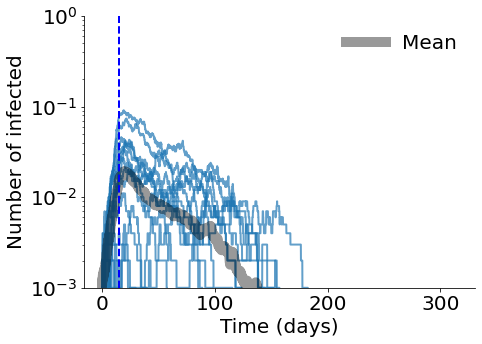

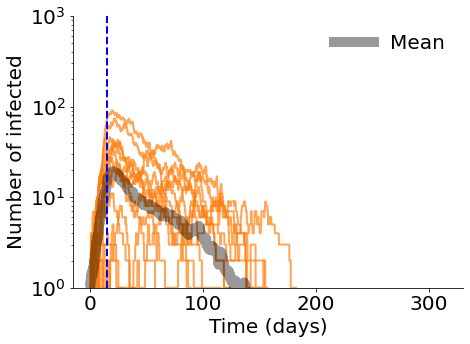

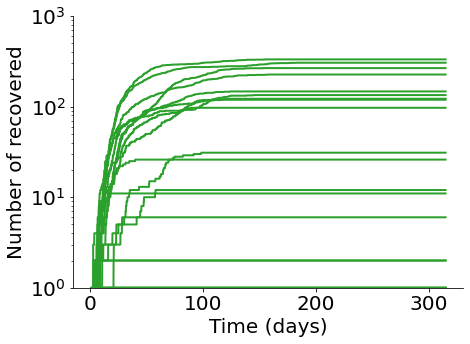

In [0]:
#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i],color='C0',alpha=0.7)
plt.plot(tvec,mean_traj,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.plot([Tint,Tint],[1/pop,1],'b--')
plt.xlabel("Time (days)")
plt.ylabel("Number of infected")
plt.ylim([1/pop,1])
plt.legend()
plt.semilogy()
plt.savefig('/content/gdrive/My Drive/COVID19 Network Simulations/figures/scenario2crowded_int.pdf',bbox_inches='tight',transparent=True)
plt.show() # NOTE: YOU MUST SAVE BEFORE SHOWING!!

#plot infected
mean_traj = sum(soln_i)/number_trials
plt.figure(figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_i[i]*pop,color='C1',alpha=0.7)
plt.plot(tvec,mean_traj*pop,color='black',alpha=0.4,linewidth=10,label='Mean')
plt.plot([Tint,Tint],[1,pop],'b--')
plt.xlabel("Time (days)")
plt.ylabel("Number of infected")
plt.ylim([1,pop])
plt.legend()
plt.semilogy()
plt.show()
#plt.savefig('scenario2sparse.pdf',bbox_inches='tight')


#plot recovered

plt.figure(figsize=(7,5))
for i in range(number_trials):
  plt.plot(tvec,soln_r[i]*pop,color='C2',alpha=1)
plt.xlabel("Time (days)")
plt.ylabel("Number of recovered")
plt.ylim([1,pop])
plt.semilogy()
plt.show()